# Decoding fMRI using nltools
written by Luke Chang 8/15/2017

This tutorial will provide an introduction to the [nltools toolbox](https://github.com/ljchang/nltools), which is loosely based off of Tor Wager's [Matlab Toolbox](https://github.com/canlab/CanlabCore) and is the analysis engine that power [neuro-learn.org](http://neuro-learn.org/).

In addition, we will try to replicate training the Picture Induced Negative Emotion Signature using rating data stored in [neurovault](http://neurovault.org/collections/1964/).  For details about the methods see our [paper](http://cosanlab.com/static/papers/Changetal2015PLoSBiology.pdf).

# Download affective rating dataset from neurovault

Here we fetch the affective rating dataset used in [Chang et al., 2015](http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002180>)
from [neurovault](http://neurovault.org/collections/504/>). In this dataset 
there are 182 subjects with approximately 5 separate beta images reflecting varying intensities
of their negative affective ratings in response to arousing IAPS images. The data will be downloaded to ~/nilearn_data,
and automatically loaded as a Brain_Data() instance.  The image metadata will be stored in data.X.



In [1]:
%matplotlib inline
from nltools.datasets import fetch_emotion_ratings

data = fetch_emotion_ratings()

 
# Basic Data Operations

The bulk of the nltools toolbox is built around the
Brain_Data() class.  This class represents imaging data as a vectorized
features by observations matrix.  Each image is an observation and each voxel
is a feature.  The concept behind the class is to have a similar feel to a pandas
dataframe, which means that it should feel intuitive to manipulate the data.




Basic Brain_Data() Operations
---------------------------------------------------------

Here are a few quick basic data operations.
Find number of images in Brain_Data() instance



In [3]:
print(len(data))

822


Find the dimensions of the data.  images x voxels



In [4]:
print(data.shape())

(822, 238955)


We can use any type of indexing to slice the data such as integers, lists
of integers, or boolean.



In [5]:
print(data[[1,6,2]])

nltools.data.Brain_Data(data=(3, 238955), Y=0, X=(3, 44), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])


Calculate the mean for every voxel over images



In [6]:
data.mean()

nltools.data.Brain_Data(data=(238955,), Y=0, X=(822, 44), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

Calculate the standard deviation for every voxel over images



In [7]:
data.std()

nltools.data.Brain_Data(data=(238955,), Y=0, X=(822, 44), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

Methods can be chained.  Here we get the shape of the mean.



In [8]:
print(data.mean().shape())

(238955,)


Brain_Data instances can be added and subtracted



In [9]:
new = data[1]+data[2]

Brain_Data instances can be manipulated with basic arithmetic operations
Here we add 10 to every voxel and scale by 2



In [10]:
data2 = (data+10)*2

Brain_Data instances can be copied 



In [11]:
new = data.copy()

Brain_Data instances can be easily converted to nibabel instances, which 
store the data in a 3D/4D matrix.  This is useful for interfacing with other
python toolboxes such as [nilearn](http://nilearn.github.io/>)



In [12]:
data.to_nifti()

Brain_Data instances can be concatenated using the append method



In [13]:
new = new.append(data[4])

Any Brain_Data object can be written out to a nifti file



In [14]:
data.write('Tmp_Data.nii.gz')

Images within a Brain_Data() instance are iterable.  Here we use a list
comprehension to calculate the overall mean across all voxels within an
image.



In [19]:
[x.mean() for x in data[:10]]

[0.26385647,
 0.45041031,
 0.42635551,
 0.19531077,
 0.58192825,
 0.14651087,
 0.44709185,
 0.60360801,
 0.28620967,
 0.0038729438]

Basic Brain_Data() Plotting
---------------------------------------------------------

There are multiple ways to plot data.  First, Brain_Data() instances can be 
converted to a nibabel instance and plotted using any plot method such as
nilearn.



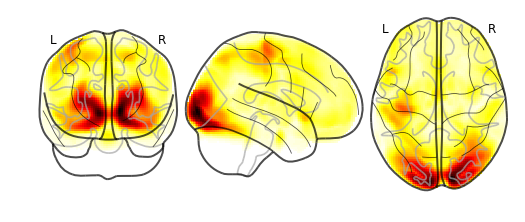

In [23]:
from nilearn.plotting import plot_glass_brain

plot_glass_brain(data.mean().to_nifti())

There is also a fast montage plotting method.  Here we plot the average image
it will render a separate plot for each image.  There is a 'limit' flag
which allows you to specify the maximum number of images to display.



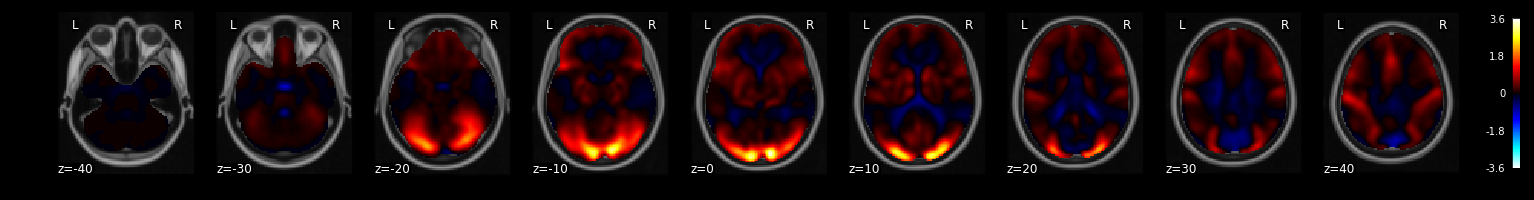

In [24]:
data.mean().plot()

We also have methods to create a more comprehensive plot from multiple orientations

Plotting unthresholded image


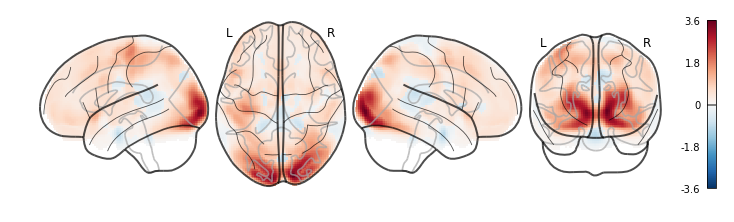

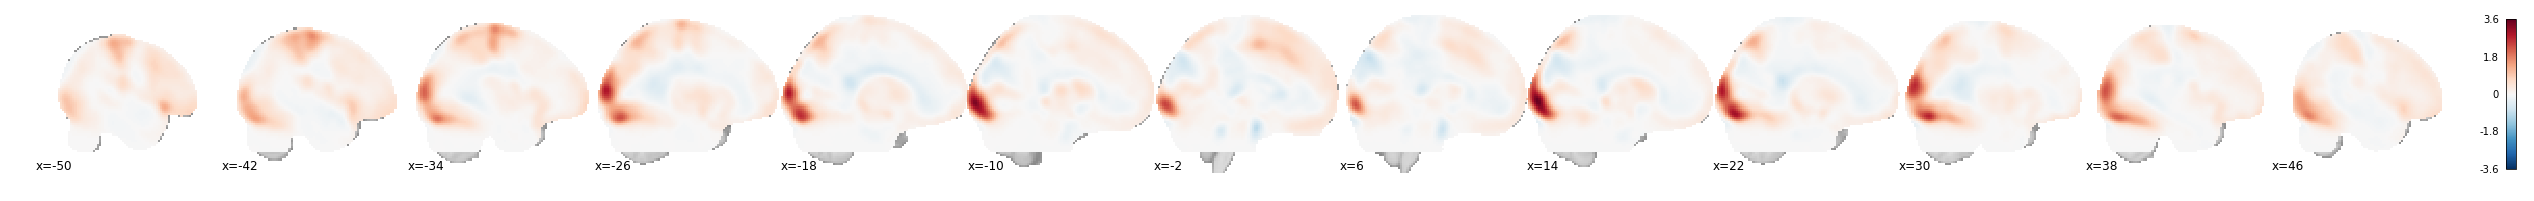

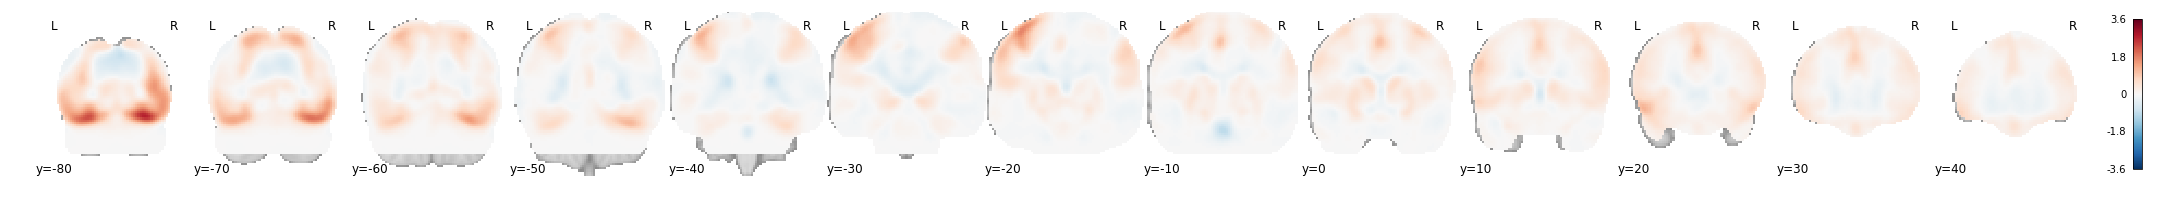

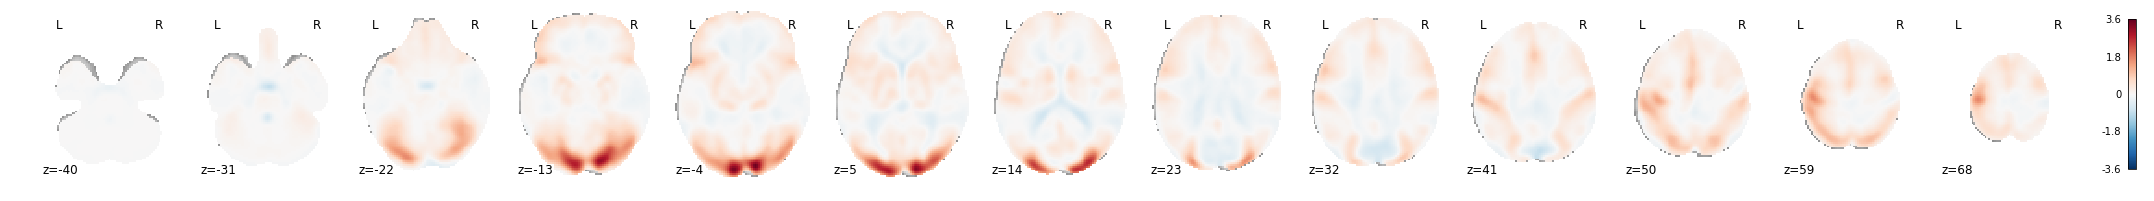

In [26]:
from nltools.plotting import plotBrain

plotBrain(data.mean())

# Multivariate Prediction
Running MVPA style analyses using multivariate regression is even easier and faster 
than univariate methods. All you need to do is specify the algorithm and 
cross-validation parameters. Currently, we have several different linear algorithms
implemented from [scikit-learn](http://scikit-learn.org/stable/).

## Prediction with Cross-Validation
Cross-validation is critical for evaluating the performance of models.  We recommend splitting the data into a training and separate holdout test sets.  The final holdout set should only be used to test the model once, while the training data can be explored and fit multiple times (though we do recommend cross-validation here too).  As an example, we will split the data in to train (2/3) and test (1/3).

In [33]:
data[data.X['Holdout']=='Train']

NotImplementedError: iLocation based boolean indexing on an integer type is not available

In [31]:
train = data[data.X['Holdout']=='Train']
test = data[data.X['Holdout']=='Test']

NotImplementedError: iLocation based boolean indexing on an integer type is not available

We can now predict the output variable is a dictionary of the most 
useful output from the prediction analyses. The predict function runs 
the prediction multiple times. One of the iterations uses all of the 
data to calculate the `weight_map`. The other iterations are to estimate 
the cross-validated predictive accuracy.

In [ ]:
stats = train.predict(algorithm='ridge', 
                    cv_dict={'type': 'kfolds','n_folds': 5,'stratified':data.Y})

Display the available data in the output dictionary

In [35]:
stats.keys()

NameError: name 'stats' is not defined

Plot the multivariate weight map

In [ ]:
stats['weight_map'].plot()

Return the cross-validated predicted data

In [ ]:
stats['yfit_xval']

## Algorithms
There are several types of linear algorithms implemented including:
Support Vector Machines (svr), Principal Components Analysis (pcr), and 
penalized methods such as ridge and lasso.  These examples use 5-fold
cross-validation holding out the same subject in each fold.

In [ ]:
subject_id = train.X['SubjectID']
svr_stats = train.predict(algorithm='svr', 
                        cv_dict={'type': 'kfolds','n_folds': 5,
                        'subject_id':subject_id}, **{'kernel':"linear"})

Lasso Regression

In [ ]:
lasso_stats = train.predict(algorithm='lasso', 
                        cv_dict={'type': 'kfolds','n_folds': 5,
                        'subject_id':subject_id}, **{'alpha':.1})

Principal Components Regression

In [ ]:
pcr_stats = train.predict(algorithm='pcr', 
                        cv_dict={'type': 'kfolds','n_folds': 5,
                        'subject_id':subject_id})

## Cross-Validation Schemes
There are several different ways to perform cross-validation.  The standard 
approach is to use k-folds, where the data is equally divided into k subsets
and each fold serves as both training and test.  
Often we want to hold out the same subjects in each fold.  
This can be done by passing in a vector of unique subject IDs that 
correspond to the images in the data frame.

In [ ]:
subject_id = data.X['SubjectID']
ridge_stats = data.predict(algorithm='ridge', 
                        cv_dict={'type': 'kfolds','n_folds': 5,'subject_id':subject_id}, 
                        plot=False, **{'alpha':.1})

Sometimes we want to ensure that the training labels are balanced across 
folds.  This can be done using the stratified k-folds method.  

In [ ]:
ridge_stats = data.predict(algorithm='ridge', 
                        cv_dict={'type': 'kfolds','n_folds': 5, 'stratified':data.Y}, 
                        plot=False, **{'alpha':.1})

Leave One Subject Out Cross-Validaiton (LOSO) is when k=n subjects.  
This can be performed by passing in a vector indicating subject id's of 
each image and using the loso flag.

In [ ]:
ridge_stats = data.predict(algorithm='ridge', 
                        cv_dict={'type': 'loso','subject_id': subject_id}, 
                        plot=False, **{'alpha':.1})

There are also methods to estimate the shrinkage parameter for the 
penalized methods using nested crossvalidation with the 
ridgeCV and lassoCV algorithms.

In [ ]:
import numpy as np

ridgecv_stats = data.predict(algorithm='ridgeCV', 
                        cv_dict={'type': 'kfolds','n_folds': 5, 'stratified':data.Y}, 
                        plot=False, **{'alphas':np.linspace(.1, 10, 5)})

# Assessing Specificity

In [ ]:
from nltools.datasets import fetch_pain

pain = fetch_pain()
pain.Y = data.X['PainLevel']

Now let's test how well the PINES generalizes to the pain test data.